In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install opencv-python # install the OpenCV library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.7 MB/s eta 0:00:00


In [ ]:

'''import urllib.request # Import the urllib.request module

def download_file(url, filename):
    urllib.request.urlretrieve(url, filename)

photon_url = 'https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
electron_url = 'https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'

download_file(photon_url, 'photon.hdf5')
download_file(electron_url, 'electron.hdf5')'''

KeyboardInterrupt: 

In [ ]:
'''df1 = 'electron.hdf5'
df2 = 'photon.hdf5'''

In [ ]:
!pip install tensorflow #installing tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [11]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def read_images_from_hdf5(hdf5_file_path):
    try:
        with h5py.File(hdf5_file_path, 'r') as hf:
            X = hf['X'][:]
            y = hf['y'][:]
            return X, y
    except Exception as e:
        print(f"Error reading HDF5 file: {e}")
        return None, None

df1= '/content/drive/MyDrive/GSOC/GSOC/task 1(A)/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
X1, y1 = read_images_from_hdf5(df1)
X1 = X1.astype('float32') / 255.
y1 = np.zeros(y1.shape[0])


df2 = '/content/drive/MyDrive/GSOC/GSOC/task 1(A)/SinglePhotonPt50_IMGCROPS_n249k_RHv1 (1).hdf5'
X2, y2 = read_images_from_hdf5(df2)
X2 = X2.astype('float32') / 255.
y2 = np.ones(y2.shape[0])




In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.4 MB/s eta 0:00:00


#model like resnet-15

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from tqdm import tqdm

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


Using device: cuda


<ipython-input-21-ed17f227a38d>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


In [22]:
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file):

        with h5py.File(photon_file, 'r') as f_photon:
            self.photon_key = list(f_photon.keys())[0]
            self.photon_data = f_photon[self.photon_key][:]  # Load entire dataset
            self.photon_size = self.photon_data.shape[0]
            print(f"Loaded photon data: {self.photon_data.shape}")

        with h5py.File(electron_file, 'r') as f_electron:
            self.electron_key = list(f_electron.keys())[0]
            self.electron_data = f_electron[self.electron_key][:]  # Load entire dataset
            self.electron_size = self.electron_data.shape[0]
            print(f"Loaded electron data: {self.electron_data.shape}")

        self.total_size = self.photon_size + self.electron_size
        print(f"Total samples: {self.total_size}")

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        if idx < self.photon_size:
            # It's a photon
            sample = self.photon_data[idx]
            label = 0
        else:
            # It's an electron
            adjusted_idx = idx - self.photon_size
            sample = self.electron_data[adjusted_idx]
            label = 1

        # Convert to PyTorch tensor
        sample = torch.tensor(sample, dtype=torch.float32)


        if sample.shape == (32, 32, 2):
            sample = sample.permute(2, 0, 1)

        return sample, torch.tensor(label, dtype=torch.long)


In [23]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        # First convolution block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolution block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet15, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        # Global average pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []

        # First block may downsample
        layers.append(ResBlock(in_channels, out_channels, stride))

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


#DATALOADER IMPLEMENTATION

In [24]:

def load_and_prepare_data():
    photon_file = df2  # Replace with actual download path
    electron_file = df1  # Replace with actual download path


    dataset = ParticleDataset(photon_file, electron_file)

    # Spliting into train (80%) and test (20%) sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=0,  #for test purpose
        pin_memory=(device.type == 'cuda')
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,#for test purpose
        pin_memory=(device.type == 'cuda')
    )

    return train_loader, test_loader

# Execute data loading
train_loader, test_loader = load_and_prepare_data()


Loaded photon data: (249000, 32, 32, 2)
Loaded electron data: (249000, 32, 32, 2)
Total samples: 498000


#MODEL LOADING

In [25]:
# Initialize model
model = ResNet15().to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)



ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

#TRAINING BATCH WITH 64(batch size 128 gives the same performance on testing)

In [26]:
# Training metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_acc = 0.0

# Number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    # Train phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for progress bar
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for inputs, labels in train_iter:
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear gradients more efficiently
        for param in model.parameters():
            param.grad = None

        # Mixed precision forward pass
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        train_iter.set_postfix({"loss": running_loss/(train_iter.n+1),
                              "acc": 100.0*correct/total})

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]")
        for inputs, labels in test_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision inference
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            test_iter.set_postfix({"loss": test_loss/(test_iter.n+1),
                                 "acc": 100.0*correct/total})

    test_loss = test_loss / len(test_loader)
    test_acc = 100.0 * correct / total

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Update learning rate
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "resnet15_best.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")



Epoch 1/20 [Train]:   0%|          | 0/6225 [00:00<?, ?it/s]<ipython-input-26-341d2532fd1b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Epoch 1/20 [Test]:   0%|          | 0/1557 [00:00<?, ?it/s]<ipython-input-26-341d2532fd1b>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Epoch 1/20 [Test]: 100%|██████████| 1557/1557 [00:10<00:00, 154.17it/s, loss=0.576, acc=70.7]


Epoch 1/20, Train Loss: 0.6035, Train Acc: 67.88%, Test Loss: 0.5741, Test Acc: 70.74%
New best model saved with accuracy: 70.74%


Epoch 2/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.99it/s, loss=0.563, acc=72.1]


Epoch 2/20, Train Loss: 0.5689, Train Acc: 71.35%, Test Loss: 0.5589, Test Acc: 72.05%
New best model saved with accuracy: 72.05%


Epoch 3/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.65it/s, loss=0.559, acc=72.2]


Epoch 3/20, Train Loss: 0.5589, Train Acc: 72.00%, Test Loss: 0.5554, Test Acc: 72.18%
New best model saved with accuracy: 72.18%


Epoch 4/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 157.28it/s, loss=0.565, acc=71.8]


Epoch 4/20, Train Loss: 0.5537, Train Acc: 72.37%, Test Loss: 0.5611, Test Acc: 71.80%


Epoch 5/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.89it/s, loss=0.553, acc=72.8]


Epoch 5/20, Train Loss: 0.5498, Train Acc: 72.69%, Test Loss: 0.5487, Test Acc: 72.78%
New best model saved with accuracy: 72.78%


Epoch 6/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 157.03it/s, loss=0.544, acc=73.5]


Epoch 6/20, Train Loss: 0.5465, Train Acc: 72.93%, Test Loss: 0.5407, Test Acc: 73.48%
New best model saved with accuracy: 73.48%


Epoch 7/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.92it/s, loss=0.558, acc=72.4]


Epoch 7/20, Train Loss: 0.5443, Train Acc: 73.10%, Test Loss: 0.5523, Test Acc: 72.38%


Epoch 8/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.96it/s, loss=0.546, acc=73.1]


Epoch 8/20, Train Loss: 0.5425, Train Acc: 73.21%, Test Loss: 0.5419, Test Acc: 73.14%


Epoch 9/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 158.50it/s, loss=0.546, acc=73.2]


Epoch 9/20, Train Loss: 0.5408, Train Acc: 73.29%, Test Loss: 0.5422, Test Acc: 73.16%


Epoch 10/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 157.43it/s, loss=0.533, acc=73.9]


Epoch 10/20, Train Loss: 0.5335, Train Acc: 73.83%, Test Loss: 0.5325, Test Acc: 73.88%
New best model saved with accuracy: 73.88%


Epoch 11/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.73it/s, loss=0.535, acc=73.9]


Epoch 11/20, Train Loss: 0.5315, Train Acc: 73.93%, Test Loss: 0.5332, Test Acc: 73.91%
New best model saved with accuracy: 73.91%


Epoch 12/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 157.31it/s, loss=0.535, acc=74]


Epoch 12/20, Train Loss: 0.5301, Train Acc: 74.06%, Test Loss: 0.5319, Test Acc: 73.96%
New best model saved with accuracy: 73.96%


Epoch 13/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 157.12it/s, loss=0.535, acc=74]


Epoch 13/20, Train Loss: 0.5289, Train Acc: 74.10%, Test Loss: 0.5317, Test Acc: 74.00%
New best model saved with accuracy: 74.00%


Epoch 14/20 [Test]: 100%|██████████| 1557/1557 [00:10<00:00, 154.22it/s, loss=0.539, acc=73.3]


Epoch 14/20, Train Loss: 0.5279, Train Acc: 74.15%, Test Loss: 0.5390, Test Acc: 73.34%


Epoch 15/20 [Test]: 100%|██████████| 1557/1557 [00:10<00:00, 155.61it/s, loss=0.537, acc=74]


Epoch 15/20, Train Loss: 0.5269, Train Acc: 74.22%, Test Loss: 0.5322, Test Acc: 74.03%
New best model saved with accuracy: 74.03%


Epoch 16/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 156.52it/s, loss=0.541, acc=73.6]


Epoch 16/20, Train Loss: 0.5257, Train Acc: 74.35%, Test Loss: 0.5375, Test Acc: 73.56%


Epoch 17/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 155.88it/s, loss=0.537, acc=74]


Epoch 17/20, Train Loss: 0.5197, Train Acc: 74.69%, Test Loss: 0.5319, Test Acc: 73.96%


Epoch 18/20 [Test]: 100%|██████████| 1557/1557 [00:09<00:00, 155.90it/s, loss=0.533, acc=74.1]


Epoch 18/20, Train Loss: 0.5179, Train Acc: 74.82%, Test Loss: 0.5286, Test Acc: 74.14%
New best model saved with accuracy: 74.14%


Epoch 19/20 [Train]:   3%|▎         | 203/6225 [00:02<01:22, 73.13it/s, loss=0.535, acc=74.9]


KeyboardInterrupt: 

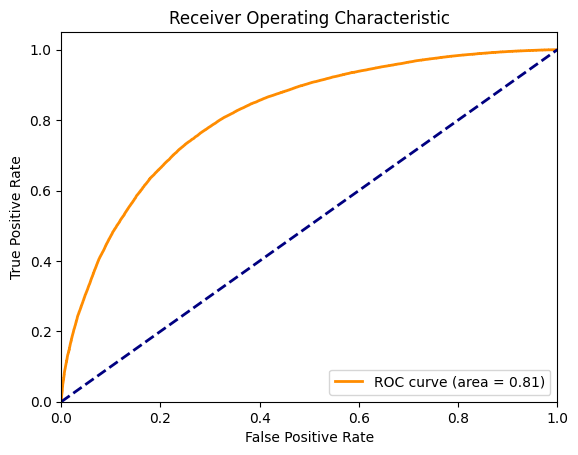

In [29]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (electron)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


In [31]:
model_save_path = "/content/drive/MyDrive/GSOC/GSOC/task 1(A)/resnet15_model.pth"  # Specify the desired path with filename
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/GSOC/GSOC/task 1(A)/resnet15_model.pth


In [33]:

from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.75      0.74     49593
           1       0.75      0.73      0.74     50007

    accuracy                           0.74     99600
   macro avg       0.74      0.74      0.74     99600
weighted avg       0.74      0.74      0.74     99600



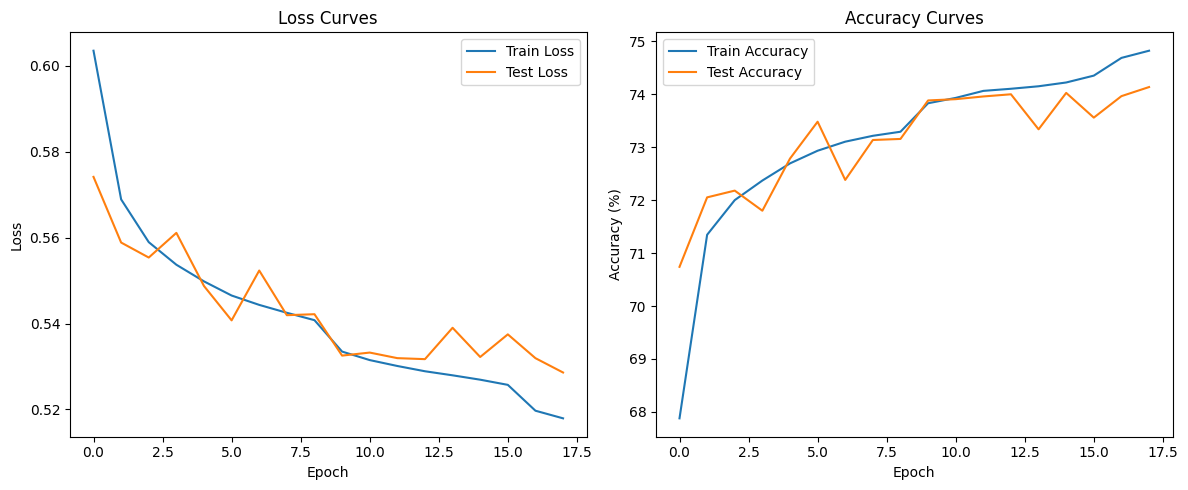

Best model accuracy: 74.14%


In [28]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

print(f"Best model accuracy: {best_acc:.2f}%")
